In [101]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from numpy.linalg import norm
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, find
from sklearn.metrics import calinski_harabasz_score
from scipy.spatial.distance import euclidean
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.decomposition import SparsePCA
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.utils import shuffle
import click
import logging
from pathlib import Path
from sklearn.utils import shuffle

row = []
column = []
matrix_data = []
with open('train.dat', 'r') as input:
    for number, lines in enumerate(input):
        lines = lines.rstrip()
        total_words = lines.split()
        count = int(len(total_words))
        for i in range(0,count,2):
            column.append(int(total_words[i]))
            matrix_data.append(int(total_words[i+1]))
            row.append(number)
matrix = csr_matrix((matrix_data,(row, column)), dtype = np.float)
tf_trans = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True)
tfid = tf_trans.fit_transform(matrix)

svd = TruncatedSVD(n_components=300, random_state=42,algorithm='arpack')
reducedmatrix=svd.fit_transform(tfid)
reducedmatrix= csr_matrix(reducedmatrix)


# Calculating Initial centroids, Recalculate centroids and Forming clusters

In [102]:
# Recalculating centroids by taking mean of all points in each cluster.
def getCentroids(mat, init_clusters):
    centroids = list()
# Calculate mean and reassign centroids for two clusters
    for itr in range(0,2):
        ind = [i for i in range(len(init_clusters)) if init_clusters[i] == itr]
        points = mat[ind,:]
        centroids.append(points.toarray().mean(0))
    recal_centroids = csr_matrix(centroids)
    return recal_centroids
#Calculating intial centroids.
def initial_Centroids(reducedmatrix,matrix):
    matrixShuffled = shuffle(matrix, random_state=0)
    cluster_index=[]
    for i in range(matrixShuffled.shape[0]):
        cluster_index.append(i)
    initial_centroids = cluster_index[:2]
    centroids = reducedmatrix[[initial_centroids[0],initial_centroids[1]],:]
    return centroids
#Forming clusters by taking centroids as reference points and calculating similarity between points
def fetch_Cluster(data, centroids):
    cluster_list = list()
    DistanceMatrix = data.dot(centroids.T)
    for itr in range(DistanceMatrix.shape[0]):
        cluster_init = DistanceMatrix[itr].toarray()
        cluster_init= cluster_init.flatten()
        cluster_index = cluster_init.argsort()[-1]
        cluster_list.append(cluster_index)
    return cluster_list

# Implementing Kmeans clustering

In [103]:
def kmeans(reducedmatrix,matrix, cluster_index):
# Calling initial centroid function and loading centroid values to fetch_cluster
    centroids = initial_Centroids(reducedmatrix,matrix)
#   For stoping condition:Considering no of iterations as 20
    for itr in range(20):
#   Calling fetch_cluster and getcentroid functions.
        init_clusters = fetch_Cluster(matrix,centroids)
        centroids = getCentroids(matrix,init_clusters)
    cluster_index1 = []
    cluster_index2 = []
    for i in range(len(init_clusters)):
        if init_clusters[i] == 0:
            cluster_index1.append(cluster_index[i])
        elif init_clusters[i] == 1:
            cluster_index2.append(cluster_index[i])

    return cluster_index1, cluster_index2


# Calculate sse

In [104]:
def cal_sse(cluster_1,cluster_2):
    sse_cluster1=0
    sse_cluster2=0
#  sum of square for points in cluster and to mean of clusters. Considering l2 norm form(Euclidean distance)
    for clusters in cluster_1:
            sse_cluster1 += (np.linalg.norm(clusters.toarray()-clusters.toarray().mean()))**2
    for clusters in cluster_2:
            sse_cluster2 += (np.linalg.norm(clusters.toarray()-clusters.toarray().mean()))**2  
    if(sse_cluster1<sse_cluster2):
        max_sse = sse_cluster2
    else:
        max_sse = sse_cluster1
    return sse_cluster1,sse_cluster2,max_sse

# Bisecting K-Means Clustering


In [105]:
def bisect_kmeans(reducedmatrix, k):
    matrix = reducedmatrix
    cluster_list = []
    cluster_index = []
    for i in range(reducedmatrix.shape[0]):
        cluster_index.append(i)
    cluster_list += [cluster_index]
#     iterate untill required no of clusters formed, i.e k=7 
    while len(cluster_list) < k:
#         Calling k means clustering which returns formed cluster indexes
        cluster_index1, cluster_index2 = kmeans(reducedmatrix,matrix,cluster_index)
#     Forming clusters by taking index points
        cluster_1 = reducedmatrix[cluster_index1,:]
        cluster_2 = reducedmatrix[cluster_index2,:]
#   Calling cal_sse function and get sse values for both clusters
        sse_cluster1,sse_cluster2,max_sse = cal_sse(cluster_1,cluster_2)
# If cluster2 has maximum sse add cluster1 points to cluster list and vice versa.
        if max_sse == sse_cluster2:
            cluster_list += [cluster_index1]
        if max_sse == sse_cluster1:
            cluster_list += [cluster_index2]
# If cluster2 is greater than cluster1 sse assign cluster2 points to matrix and recalculate kmeans and form clusters 
        if sse_cluster2 > sse_cluster1:
            cluster_index = cluster_index2
            matrix = cluster_2
        elif sse_cluster1 > sse_cluster2:
            cluster_index = cluster_index1
            matrix = cluster_1
        
    return cluster_list


In [106]:
Cluster_count = list()
Accuracy_scores = list()
# Calculate clusters for 3 to 22 with stepsize of 2
for k in range(3,22,2):
    output = []
    for i in range(matrix.shape[0]):
        output.append(0)
#         Calling bisect kmeans
    clustering = bisect_kmeans(reducedmatrix,k)
    for i in range(len(clustering)):
        for j in range(len(clustering[i])):
            output[clustering[i][j]] = i+1
    print("Clusters:  ",k)
    print("Accuracy Score: ")
    print(calinski_harabasz_score(reducedmatrix.toarray(),output))
    if (k==7):
        f = open("output_check.dat", "w")
        f.write("\n".join(map(lambda y: str(y), output)))
        f.close()
    Accuracy_score = calinski_harabasz_score(reducedmatrix.toarray(), output)
    Cluster_count.append(k)
    Accuracy_scores.append(Accuracy_score)
# output = []
# for i in range(matrix.shape[0]):
#     output.append(0)
# kValues = list()
# scores = list()
# k=7
# result = bisect_kmeans(reducedmatrix,k)
# for i in range(len(result)):
#     for j in range(len(result[i])):
#         output[result[i][j]] = i+1
# print("Accuracy Score: ",k)
# print(calinski_harabasz_score(reducedmatrix.toarray(),output))

# if (k==7):
#     f = open("result_check.dat", "w")
#     f.write("\n".join(map(lambda y: str(y), output)))
#     f.close()
# Accuracy_score = calinski_harabasz_score(reducedmatrix.toarray(), output)
# Cluster_count.append(k)
# Accuracy_scores.append(Accuracy_score)

Clusters:   3
Accuracy Score: 
188.10888564048085
Clusters:   5
Accuracy Score: 
173.97394126417285
Clusters:   7
Accuracy Score: 
137.0226695136572
Clusters:   9
Accuracy Score: 
108.2947458161475
Clusters:   11
Accuracy Score: 
87.54579672799912
Clusters:   13
Accuracy Score: 
74.28126151288033
Clusters:   15
Accuracy Score: 
64.1148708424891
Clusters:   17
Accuracy Score: 
56.23633354844469
Clusters:   19
Accuracy Score: 
50.10121856989747
Clusters:   21
Accuracy Score: 
45.194576852407344


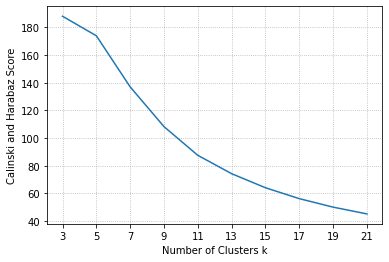

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(Cluster_count, Accuracy_scores)
plt.xticks(Cluster_count, Cluster_count)
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski and Harabaz Score')
plt.grid(linestyle='dotted')

plt.savefig('plot_2.png')
plt.show()

